# *k*-Nearest Neighbors

This notebook implements k-nearest neighbors, which is a nonparametric machine learning algorithm. Abbreviated as knn, the algorithm is based on the idea that similar data points are grouped together and close in proximity.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the Seaborn theme
sns.set_theme()

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## The Data

The model will be trained using the [Hawks](https://r-data.pmagunia.com/dataset/r-dataset-package-stat2data-hawks) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Implementing the Algorithm

The class below contains methods that are useful to implementing the *k*-nearest neighbors algorithm.

For details about the algorithm, check out the `README.md` file of this `knn` directory. In summary, we calculate the distance from a test data point to every point in the training set, find the k nearest, and decide the final prediction based on a majority score.

In [3]:
class kNN:
    """
    A class with the functionalities to perform the k-nearest neighbors algorithm

    ...

    Attributes
    ----------
    None
    
    """

    #def __init__(self):
    #    self.k = 1
    
    def distance(self, p, q):
        """
        Calculates the Euclidean distance between p and q
        """
        return np.sqrt((p - q) @ (p - q))
    
    def get_knn(self, point, training_features, training_labels, k):
        """
        Obtain the k nearest neighbors by distance for an inputted point
        """
        # Create an empty list to store neighbors and distances
        neighbors = []

        for p, label in zip(training_features, training_labels):
            d = self.distance(point, p)
            temp_data = [p, label, d]
            neighbors.append(temp_data)
        
        neighbors.sort(key = lambda x : x[-1])
    
        return neighbors[:k]

    def predict(self, point, training_features, training_labels, k, regression = False):
        """
        Obtain a prediction based on the kNN algorithm for an inputted point
        """
        neighbors = self.get_knn(point, training_features, training_labels, k)

        if regression == False:
            labels = [x[1] for x in neighbors]
            return max(labels, key = labels.count)
        else:
            return sum(x[1] for x in neighbors)/k

    def classification_error(self, test_features, test_labels,
                             training_features, training_labels, k):
        """
        Compute the classification error of a testing set (classification tasks only)
        """
        error = 0
        for point, label in zip(test_features, test_labels):
            error += label != self.predict(point, training_features, training_labels, k)
        return error/len(test_features)
    
    def classification_error_plot(self, test_features, test_labels,
                                  training_features, training_labels):
        """
        Plot the classification error of the testing set over a range of k-values
        """
        possible_k = [k for k in range(3, int(np.ceil(np.sqrt(len(training_labels)))), 2)]
        errors = [self.classification_error(test_features, test_labels,
                                            training_features, training_labels, k) for k in possible_k]

        plt.figure(figsize = (8, 6))
        plt.plot(possible_k, errors, color = 'red', marker = "o")
        plt.xlabel('k', fontsize = 14)
        plt.ylabel('Classification Error', fontsize = 14)
        plt.xticks(possible_k)

    def plot_confusion_matrix(self, test_features, test_labels, 
                              training_features, training_labels, k, classes):
        """
        Plot the resulting confusion matrix for class predictions given training and testing data.
        """
        # Obtain predictions
        y_pred = [self.predict(test_features[i], training_features,
                                training_labels, k) for i in range(0, len(test_labels))]

        # Obtain confusion matrix
        cf_matrix = confusion_matrix(test_labels, y_pred, labels=classes)

        # View the confusion matrix using the seaborn package
        plt.figure(figsize = (6, 4))
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, fmt='g')

        ax.set_title('Confusion Matrix\n', fontsize = 14);
        ax.set_xlabel('\nPredicted Values', fontsize = 12)
        ax.set_ylabel('Actual Values ', fontsize = 12);

        ## Ticket labels - List must be in alphabetical order
        ax.xaxis.set_ticklabels(classes)
        ax.yaxis.set_ticklabels(classes)
        plt.show()

## Model 1: KNN with 2 features: wing & tail length

First, I run KNN with the two features that have been commonly used as a starting point for classification tasks.

In [4]:
# Data preparation step
X = hawks[["Wing", "Tail"]].to_numpy()
y = hawks["Species"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

The first step is to determine the value of *k* that is most appropriate. This will be determined by trying a set of *k*'s and determining which produces the least error on the test set, keeping into account the following:

* Small values of *k* can lead to overfitting and higher influences of noise in the data
* Large values of *k* are computationally expensive and can lead to underfitting
* Even values of *k* cause complications when ties arise

The plot below displays the classification error for a range of *k*'s from 3 to $\sqrt n$, a widely accepted optimal value for *k*, where n is the number of training samples.

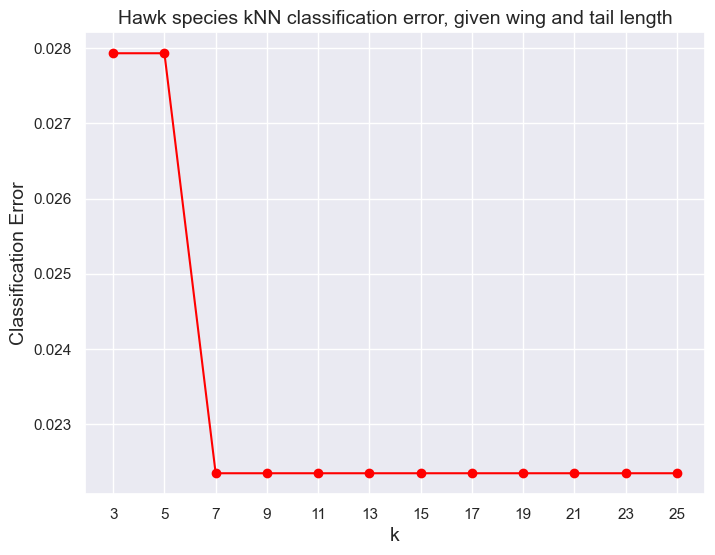

In [5]:
hawks_knn = kNN()

hawks_knn.classification_error_plot(X_test, y_test, X_train, y_train)
plt.title("Hawk species kNN classification error, given wing and tail length", fontsize = 14)
plt.show()

Choosing k = 7 results in the lowest classification error while not being too complex.

Next, the confusion matrix when using kNN on the testing data set:

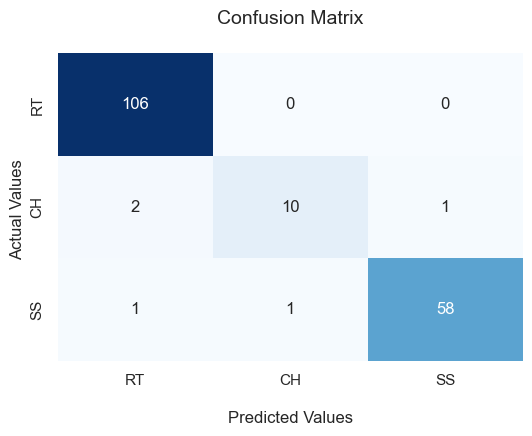

In [6]:
classes = ["RT", "CH", "SS"]
hawks_knn.plot_confusion_matrix(X_test, y_test, X_train, y_train, 5, classes = classes)

Most of the testing set is accurately classified!

Now, I will show the predictions for select data points to show what's going on behind the scenes of this algorithm.

In [7]:
print(X_test[13], y_test[13]) # show the features and the true label

print(hawks_knn.predict(X_test[13], X_train, y_train, 7)) # show the predicted label, k = 7

hawks_knn.get_knn(X_test[13], X_train, y_train, 7) # show the 7 nearest by distance

[396. 227.] RT
RT


[[array([397., 228.]), 'RT', 1.4142135623730951],
 [array([398., 225.]), 'RT', 2.8284271247461903],
 [array([394., 225.]), 'RT', 2.8284271247461903],
 [array([396., 230.]), 'RT', 3.0],
 [array([393., 226.]), 'RT', 3.1622776601683795],
 [array([397., 224.]), 'RT', 3.1622776601683795],
 [array([399., 228.]), 'RT', 3.1622776601683795]]

In [8]:
print(X_test[34], y_test[34]) # show the features and the true label

print(hawks_knn.predict(X_test[34], X_train, y_train, 7)) # show the predicted label, k = 7

hawks_knn.get_knn(X_test[34], X_train, y_train, 7) # show the 7 nearest by distance

[250. 192.] SS
CH


[[array([252., 185.]), 'CH', 7.280109889280518],
 [array([240., 192.]), 'CH', 10.0],
 [array([237., 195.]), 'CH', 13.341664064126334],
 [array([262., 200.]), 'RT', 14.422205101855956],
 [array([239., 182.]), 'CH', 14.866068747318506],
 [array([235., 193.]), 'CH', 15.033296378372908],
 [array([261., 203.]), 'CH', 15.556349186104045]]

The demonstration of k-nearest neighbors on these data points shows how the algorithm finds the nearest points and then uses the majority to produce the final prediction.

In the first case using test point 13, the correct label is produced. In the second case using test point 34, the wrong prediction is made, but the nearest 7 observations are all not the Sharp-shinned species.

## Model 2: KNN with 5 features

In addition to wing and tail length, I now run *k*-nearest neighbors with 3 additional hawk features: body weight, culmen length, and hallux (killing talon) length.

An underlying question is whether the inclusion of more features will improve the hawk species classification accuracy.

In [9]:
# Data preparation step: use 5 features now instead of the original 2
X = hawks.drop("Species", axis=1).to_numpy()
# the y-values stay the same

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

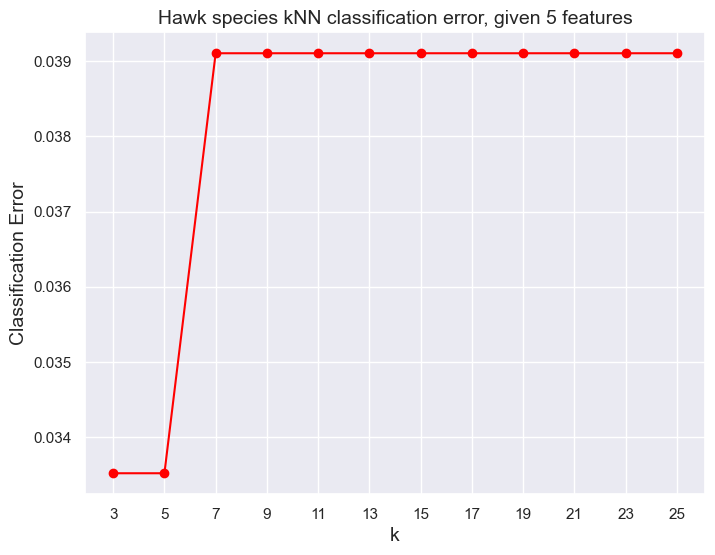

In [10]:
hawks_knn.classification_error_plot(X_test, y_test, X_train, y_train)
plt.title("Hawk species kNN classification error, given 5 features", fontsize = 14)
plt.show()

At all values of *k*, the classification error when 5 features are used is larger compared to when only the original 2 features are used. Also, as the value of *k* increases, the classification error even increases.

Here, good values for the parameter k would be 3 or 5, seeing how they lead to the least classification errors. Considering how low values of *k* make predictions more prone to noise in the data, I will proceed with k = 5.

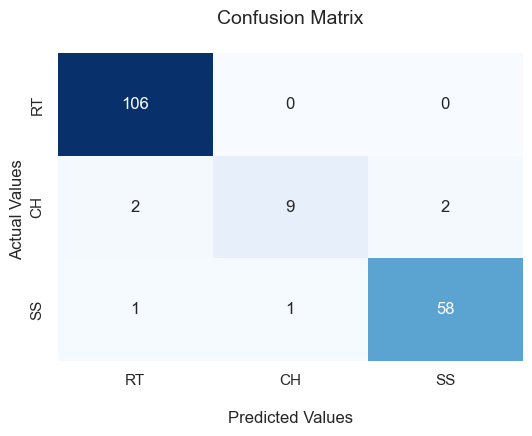

In [11]:
hawks_knn.plot_confusion_matrix(X_test, y_test, X_train, y_train, 5, classes = classes)

Based on the confusion matrix above, most of the testing set is accurately classified once again! There are additional errors compared to the previous 2 feature setup as expected by the increase in classification error mentioned previously.

Now, the predictions for select data points to show the behind the scenes.

In [12]:
print(X_test[13], y_test[13]) # show the features and the true label

print(hawks_knn.predict(X_test[13], X_train, y_train, 5)) # show the predicted label, k = 5

hawks_knn.get_knn(X_test[13], X_train, y_train, 5) # show the 5 nearest by distance

[ 396.   227.  1010.    24.    26.9] RT
RT


[[array([ 397. ,  228. , 1010. ,   27.1,   31.4]), 'RT', 5.6444663166680344],
 [array([ 397. ,  222. , 1010. ,   25. ,   30.6]), 'RT', 6.3788713735268265],
 [array([ 393. ,  222. , 1010. ,   26.3,   30.8]), 'RT', 7.382411530116702],
 [array([ 390. ,  230. , 1015. ,   28. ,   30.1]), 'RT', 9.810198774744578],
 [array([ 390. ,  231. , 1000. ,   25.1,   28.3]), 'RT', 12.45672509129105]]

In [13]:
print(X_test[34], y_test[34]) # show the features and the true label

print(hawks_knn.predict(X_test[34], X_train, y_train, 5)) # show the predicted label, k = 5

hawks_knn.get_knn(X_test[34], X_train, y_train, 5) # show the 5 nearest by distance

[250.  192.  470.   18.9  25.3] SS
CH


[[array([261. , 216. , 455. ,  17.1,  26.8]), 'CH', 30.454720487963765],
 [array([258. , 214. , 490. ,  18. ,  24.2]), 'CH', 30.822394455979566],
 [array([265. , 225. , 464. ,  19.2,  24.1]), 'CH', 36.763160908714035],
 [array([255. , 214. , 440. ,  18.6,  22.8]), 'CH', 37.62100477127106],
 [array([261. , 203. , 505. ,  19.2,  25.1]), 'CH', 38.303133031124226]]

The nearest observations by distance all have the same label. In the first case using test point 13, this leads to the species being identified correctly, but in the second case using test point 34, this leads to an incorrect classification once again.

### Conclusions: model 2 vs. model 1

All in all, there is no clear benefit to using these 5 features over the original 2. The classification error doesn't meaningfully decrease (and even slightly increased) with the increase in complexity of computation. Given these two models, I would rather proceed with model 1 if I were to clasify hawk species using kNN.

## Using scikit-learn

Below, I provide an example of how you would use the scikit-learn library to perform *k*-nearest neighbors for a classification task, using the same training/testing dataset involving 5 features to predict hawk species.

In [14]:
import sklearn.neighbors
import warnings
warnings.filterwarnings('ignore') # surpress deprecation warnings

model = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, y_train)

print("Predicted:", model.predict([X_test[1]]),
      "\nActual:", y_test[1])
nearest = model.kneighbors([X_test[1]])
print("Nearest distances:", nearest[0])
print("Nearest labels:", y_train[nearest[1]])

Predicted: ['SS'] 
Actual: SS
Nearest distances: [[ 9.59426912  9.95188424 10.73685243 10.74476617 11.04264461]]
Nearest labels: [['SS' 'SS' 'SS' 'SS' 'SS']]
